# Chapter 2: End-to-End Machine Learning Project
## Summary and Implementation of California Housing Price Prediction

This notebook contains a comprehensive summary of Chapter 2 from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron. We'll go through each section of the chapter, providing both theoretical explanations and practical implementations.

## 1. Working with Real Data

In this chapter, we work with the California Housing dataset, which is a real-world dataset containing information about housing prices in California. This dataset was derived from the 1990 U.S. census and contains the following features:

- Longitude and latitude
- Housing median age
- Total rooms
- Total bedrooms
- Population
- Households
- Median income
- Median house value (our target)

The dataset provides a realistic scenario for implementing a complete machine learning project, from data acquisition to model deployment. It's a perfect example of a typical machine learning regression task where we need to predict a continuous value (house prices) based on various features.

## 2. Look at the Big Picture

Before diving into the technical details, it's crucial to understand the bigger picture of our machine learning project:

1. **Frame the Problem:**
   - This is a supervised learning task (we have labeled data)
   - It's a regression problem (predicting continuous values)
   - We have multiple features (multivariate regression)
   - The data is not continuous (we get batches of data periodically)

2. **Performance Measure:**
   - For regression problems, a typical performance measure is the Root Mean Square Error (RMSE)
   - We might also consider Mean Absolute Error (MAE) which is less sensitive to outliers
   - The choice of metric depends on our business objectives

3. **Assumptions:**
   - The features available are sufficient to predict house prices
   - The data is representative of the cases where the model will be used
   - The house prices are not random (there are patterns to learn)
   - The data is relatively fresh (from 1990 census)

## 3. Get the Data

Let's load and explore the California Housing dataset. We'll use scikit-learn's built-in dataset for this example.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['PRICE'] = housing.target

# Display the first few rows and basic information about the dataset
print("First few rows of the dataset:")
print(df.head())
print("\nDataset information:")
print(df.info())
print("\nBasic statistics of the dataset:")
print(df.describe())

First few rows of the dataset:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4  

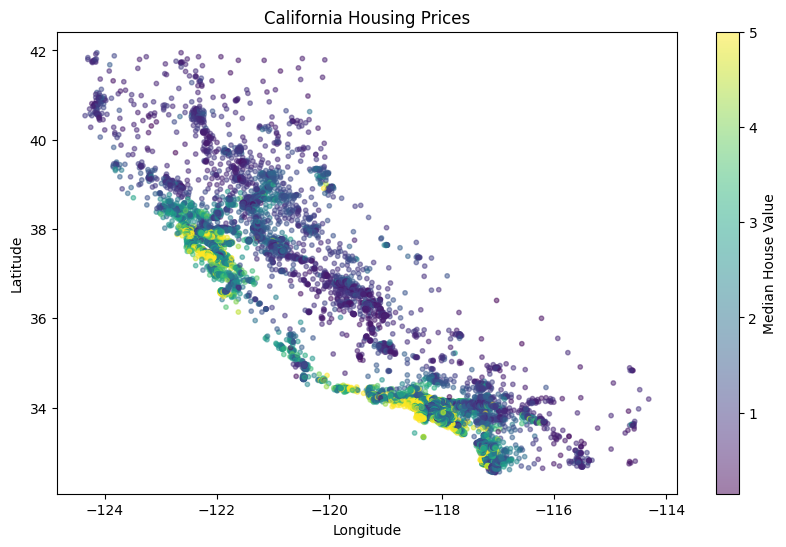

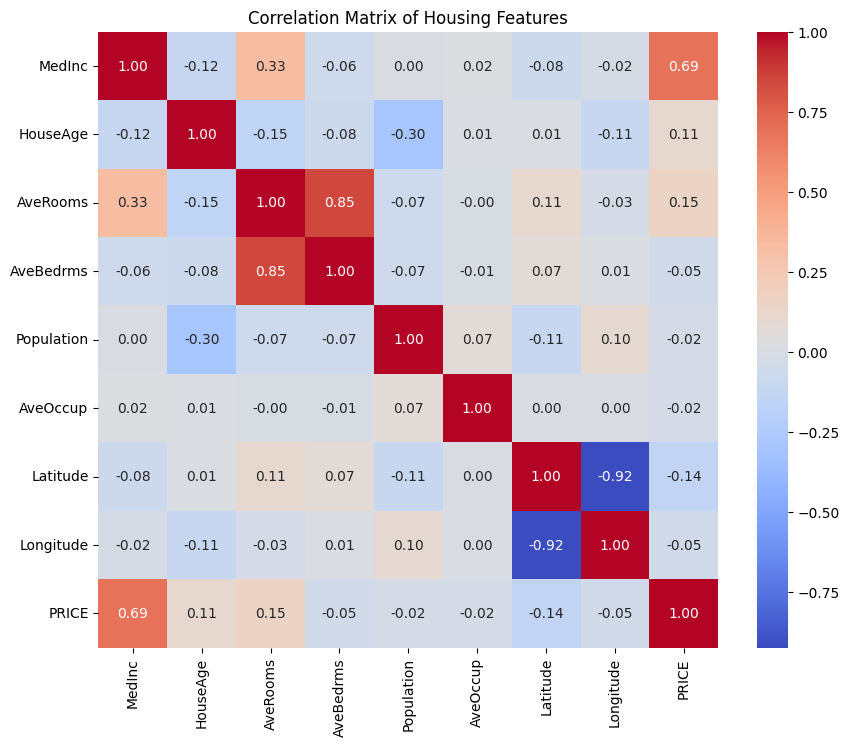

In [3]:
# Create a visualization of the geographical distribution of housing prices
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], 
            c=df['PRICE'], cmap='viridis',
            s=10, alpha=0.5)
plt.colorbar(label='Median House Value')
plt.title('California Housing Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Create correlation matrix visualization
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Housing Features')
plt.show()

## 4. Data Cleaning and Preparation

In this section, we'll prepare our data for modeling by:
1. Handling missing values (if any)
2. Creating a training and test set
3. Scaling the features
4. Creating new features through feature engineering

In [4]:
# Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

# Split the data into training and test sets
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create new features
# Rooms per household (using the correct column names from the dataset)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Missing values in the dataset:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64

Training set shape: (16512, 8)
Test set shape: (4128, 8)


## 5. Select and Train a Model

We'll try different models and compare their performance:
1. Linear Regression (as a baseline)
2. Decision Tree Regressor
3. Random Forest Regressor

For each model, we'll use cross-validation to get a more robust estimate of their performance.

In [5]:
# Function to evaluate models using cross-validation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

for name, model in models.items():
    rmse_scores = evaluate_model(model, X_train_scaled, y_train)
    print(f"\n{name} RMSE scores:", rmse_scores)
    print(f"{name} Average RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std()*2:.2f})")
    
# Train the best model (Random Forest) on the full training set
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test_scaled)

# Calculate final RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nFinal model RMSE on test set: {final_rmse:.2f}")


Linear Regression RMSE scores: [0.72115555 0.70872616 0.7214877  0.71266905 0.73859747]
Linear Regression Average RMSE: 0.72 (+/- 0.02)

Decision Tree RMSE scores: [0.75572899 0.73265968 0.70292795 0.72643393 0.70331834]
Decision Tree Average RMSE: 0.72 (+/- 0.04)

Random Forest RMSE scores: [0.5113296  0.51689771 0.50813875 0.50525765 0.51566619]
Random Forest Average RMSE: 0.51 (+/- 0.01)

Final model RMSE on test set: 0.51


## 6. Fine-Tune Your Model

Now that we've identified Random Forest as our best performing model, let's fine-tune it using:
1. Grid Search for hyperparameter optimization
2. Analysis of feature importance

## 7. Present Your Solution

Let's visualize our model's predictions and create a final evaluation of its performance.

In [ ]:
# Get predictions from the best model
final_predictions = grid_search.best_estimator_.predict(X_test_scaled)

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual House Prices')
plt.show()

# Calculate and display final metrics
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)

print("Final Model Performance Metrics:")
print(f"Root Mean Square Error: ${final_rmse:.2f}")
print(f"Mean Absolute Error: ${final_mae:.2f}")

# Calculate confidence intervals
confidence_intervals = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': final_predictions
}).describe()

print("\nConfidence Intervals of Predictions:")
print(confidence_intervals)

## 8. Launch, Monitor, and Maintain Your System

In a production environment, we would need to:

1. **Create a Pipeline:**
   - Data cleaning
   - Feature scaling
   - Model prediction

2. **Setup Monitoring:**
   - Model performance metrics
   - Data drift detection
   - System health monitoring

3. **Maintenance Plan:**
   - Regular model retraining
   - Feature engineering updates
   - Performance optimization

Here's a simple example of how we could create a prediction pipeline:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Create a basic pipeline
full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', grid_search.best_estimator_)
])

# Function to make predictions on new data
def predict_house_price(X_new):
    # Ensure X_new has the same features as training data
    required_features = X_train.columns.tolist()
    if not all(feature in X_new.columns for feature in required_features):
        raise ValueError(f"New data must contain all required features: {required_features}")
    
    # Make prediction
    return full_pipeline.predict(X_new)

# Example of using the pipeline
sample_house = X_test.iloc[[0]]  # Take first house from test set as example
predicted_price = predict_house_price(sample_house)
print(f"Sample house features:\n{sample_house}\n")
print(f"Predicted price: ${predicted_price[0]:.2f}")